# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt

import os
import sys
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 
print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:
from collections import defaultdict
verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:

cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values


------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

## TF-IDF using stopwords, ngram, and C value

In [7]:
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
p = len(X) // 10 * 9
#tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=300 )
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3, min_df=5)
tfidf_vect.fit(X[0:p])
X_train_tfidf_vect = tfidf_vect.transform(X[0:p])
X_test_tfidf_vect = tfidf_vect.transform(X[p:])

model = LogisticRegression(solver='lbfgs', class_weight='balanced')
model.fit(X_train_tfidf_vect, Y[0:p])
preds = model.predict(X_test_tfidf_vect)
precision, recall, fscore, support = score(Y[p:], preds, average='binary')
print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
print('precision: {0:.4f}'.format(precision))
print('recall   : {0:.4f}'.format(recall))
print('fscore   : {0:.4f}'.format(fscore))


from sklearn.model_selection import GridSearchCV

params = {'C':[0.01, 0.1, 1, 5, 10]}
grid_cv_lr = GridSearchCV(model,param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_lr.fit(X_train_tfidf_vect, Y[:p])
print(grid_cv_lr.best_params_)

print("TF-IDF Dimension: ", len(tfidf_vect.vocabulary_))


accuracy : 0.9716
precision: 0.9500
recall   : 0.8261
fscore   : 0.8837
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 0.1}
TF-IDF Dimension:  4443


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


## TF-IDF Train & Predict

In [8]:
from sklearn.pipeline import Pipeline

model = defaultdict()
model = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3, min_df=5)),
    ('lr_clf', LogisticRegression(solver='lbfgs',class_weight='balanced', C=0.1))
])
p = len(X) // 10 * 9

model.fit(X[0:p], Y[0:p])
preds = model.predict(X[p:])
print(preds)
accuracy = accuracy_score(Y[p:], preds)
precision, recall, fscore, support = score(Y[p:], preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
accuracy: 0.9602272727272727
precision: [0.97402597 0.86363636]
recall: [0.98039216 0.82608696]
fscore: [0.9771987  0.84444444]
support: [153  23]


## TF-IDF + Logistic Regression on CR-00-00-00-00

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression

verbose = False
    
numdoc = defaultdict()

model = LogisticRegression(solver='lbfgs', class_weight='balanced')


def predict_by_class_tfidf(dfset: defaultdict,cls: str) -> float:
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 
        
        tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3, min_df=5)
        tfidf_vect.fit(X_train)
        X_train_tfidf = tfidf_vect.transform(X_train)
        X_test_tfidf = tfidf_vect.transform(X_test)
        
        model.fit(X_train_tfidf, Y_train)
        out = model.predict(X_test_tfidf)

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
            
        #print(preds)

        n_iter += 1
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall: tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1])



cls = 'CR-00-00-00-00'


predict_by_class_tfidf(dfset, cls)

------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679


(0.9422, 0.8498, 0.8245, 0.837, 302)

## Download and Load GloVe

In [10]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip
from tqdm import tqdm

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))

400000it [00:24, 16224.01it/s]

Found 400000 word vectors.


# GloVE

## GloVe Train & Predict

In [11]:
cls = 'CR-00-00-00-00'

import numpy as np
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack



from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import punkt
stop_words = stopwords.words('english')

# Train and Test Split
p = len(X) // 10 * 9
train_text = X[:p]
test_text = X[p:]


print("Checkpoint1 - Data Read Complete")


hit = 0
all_words = 0
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    global hit, all_words
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    hit += len(M)
    all_words += len(words)
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_text)]

print('Mean Train Word Hit Rate(\%)', hit / all_words * 100)
hit = 0
all_words = 0

xtest_glove = [sent2vec(x) for x in tqdm(test_text)]
print('Mean Test Word Hit Rate(\%)', hit / all_words * 100)

print('Checkpoint2 -Normalized Vector for Sentences are created')

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

model = LogisticRegression(solver='sag', class_weight='balanced')

train_target = Y[:p]
test_target = Y[p:]

model.fit(xtrain_glove, train_target)
preds = model.predict(xtest_glove)

print(preds)
accuracy = accuracy_score(test_target, preds)
precision, recall, fscore, support = score(test_target, preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))



params = {'C': [1,10,20,30,40]}
grid_cv_lr = GridSearchCV(model,param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_lr.fit(xtrain_glove, train_target)
print(grid_cv_lr.best_params_)

  0%|          | 0/1503 [00:00<?, ?it/s]

Checkpoint1 - Data Read Complete


 63%|██████▎   | 111/176 [00:00<00:00, 506.22it/s]

Mean Train Word Hit Rate(\%) 99.58181372991224


100%|██████████| 176/176 [00:00<00:00, 554.92it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Test Word Hit Rate(\%) 99.61077662227088
Checkpoint2 -Normalized Vector for Sentences are created
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
accuracy: 0.9147727272727273
precision: [0.99285714 0.61111111]
recall: [0.90849673 0.95652174]
fscore: [0.94880546 0.74576271]
support: [153  23]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.9s finished


{'C': 30}


## Custom Logistic Regression

In [12]:
class CustomLogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # Stable Logistic Cross-Entropy
    def __loss(self, z, y):
        return y * np.logaddexp(0, -z) + (1-y) * np.logaddexp(0, z)
    
    
    #def __loss(self, h, y):
    #    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            #loss = self.__loss(h, y)
            loss = self.__loss(z,y) 
                
            if(self.verbose ==True and i % 10000 == 0):
                print(f'loss: {loss} \t')
    
    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()

## GloVE + Custom Logistic Regression on CR-00-00-00-00

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

verbose = False
    
numdoc = defaultdict()

classifier = defaultdict()

    
def predict_by_class_glove(dfset: defaultdict,cls: str) -> float:
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)

    print('Checkpoint2 -Normalized Vector for Sentences are created')
    


    for train_index, test_index in kfold.split(X_glove, Y):

        X_train, X_test = X_glove[train_index], X_glove[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Scikit-Learn
        classifier[cls] = LogisticRegression(solver='sag', class_weight='balanced', C=10)
        
        # Custom
        #classifier[cls] = CustomLogisticRegression(lr=0.1, num_iter=300000)
        #classifier[cls] = CustomLogisticRegression(lr=0.1, num_iter=100000)
        
        
        
        
        classifier[cls].fit(X_train, Y_train)
        out = classifier[cls].predict(X_test)

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
            
        #print(preds)

        n_iter += 1
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall:   tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1])



#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class_glove(dfset, cls)

100%|██████████| 1679/1679 [00:03<00:00, 515.69it/s]


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


(0.9089, 0.6976, 0.8709, 0.7747, 302)

# Entire Data 

## Build Models and Calculating Accuracies

In [14]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

class_list = df.columns[2:]
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in class_list:
    preprocessing(dfset, cls)
    ret = predict_by_class_glove(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

  3%|▎         | 56/1848 [00:00<00:03, 535.95it/s]

Index(['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00',
       'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00',
       'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00',
       'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00',
       'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00',
       'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00',
       'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00',
       'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00',
       'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00'],
      dtype='object')


100%|██████████| 1848/1848 [00:03<00:00, 519.26it/s]


------------------------------------

0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7652, 0.0566, 0.963, 0.107, 27)


100%|██████████| 1590/1590 [00:03<00:00, 515.96it/s]


------------------------------------

0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.917, 0.401, 0.8495, 0.5448, 93)


100%|██████████| 1164/1164 [00:02<00:00, 518.94it/s]


------------------------------------

0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.8995, 0.4699, 0.8113, 0.5952, 106)


100%|██████████| 1679/1679 [00:03<00:00, 515.09it/s]


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 44/1393 [00:00<00:03, 393.53it/s]

statistics (0.9089, 0.6976, 0.8709, 0.7747, 302)


100%|██████████| 1393/1393 [00:02<00:00, 506.43it/s]


------------------------------------

0.0    1381
1.0      12
Name: CR-01-00-00-00, dtype: int64
data set size 1393
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.6181, 0.0131, 0.5833, 0.0256, 12)


100%|██████████| 1402/1402 [00:02<00:00, 517.95it/s]


------------------------------------

0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
data set size 1402
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.6155, 0.0112, 0.4615, 0.0218, 13)


100%|██████████| 1404/1404 [00:02<00:00, 519.45it/s]


------------------------------------

0.0    1393
1.0      11
Name: CR-06-00-00-00, dtype: int64
data set size 1404
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7457, 0.0085, 0.2727, 0.0165, 11)


100%|██████████| 1969/1969 [00:03<00:00, 516.93it/s]


------------------------------------

0.0    1958
1.0      11
Name: CR-10-00-00-00, dtype: int64
data set size 1969
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.6805, 0.0095, 0.5455, 0.0187, 11)


100%|██████████| 1813/1813 [00:03<00:00, 511.40it/s]


------------------------------------

0.0    1789
1.0      24
Name: ED-00-00-00-00, dtype: int64
data set size 1813
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.8395, 0.0412, 0.5, 0.0762, 24)


100%|██████████| 1944/1944 [00:03<00:00, 506.24it/s]


------------------------------------

0.0    1866
1.0      78
Name: ES-00-00-00-00, dtype: int64
data set size 1944
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.8781, 0.1907, 0.6282, 0.2925, 78)


100%|██████████| 1876/1876 [00:03<00:00, 515.79it/s]


------------------------------------

0.0    1866
1.0      10
Name: ES-01-00-00-00, dtype: int64
data set size 1876
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7271, 0.0098, 0.5, 0.0192, 10)


100%|██████████| 1992/1992 [00:03<00:00, 519.89it/s]


------------------------------------

0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
data set size 1992
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7174, 0.0124, 0.5385, 0.0243, 13)


100%|██████████| 2042/2042 [00:03<00:00, 515.94it/s]


------------------------------------

0.0    1685
1.0     357
Name: FA-00-00-00-00, dtype: int64
data set size 2042
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
  3%|▎         | 56/2011 [00:00<00:03, 555.24it/s]

statistics (0.9329, 0.7477, 0.93, 0.829, 357)


100%|██████████| 2011/2011 [00:03<00:00, 507.28it/s]


------------------------------------

0.0    2001
1.0      10
Name: FA-05-00-00-00, dtype: int64
data set size 2011
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7931, 0.0097, 0.4, 0.0189, 10)


100%|██████████| 1791/1791 [00:03<00:00, 519.91it/s]


------------------------------------

0.0    1781
1.0      10
Name: FA-06-00-00-00, dtype: int64
data set size 1791
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.3177, 0.0073, 0.9, 0.0145, 10)


100%|██████████| 1968/1968 [00:03<00:00, 538.80it/s]


------------------------------------

0.0    1927
1.0      41
Name: FA-07-00-00-00, dtype: int64
data set size 1968
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.6585, 0.0512, 0.878, 0.0968, 41)


100%|██████████| 1517/1517 [00:02<00:00, 508.23it/s]


------------------------------------

0.0    1504
1.0      13
Name: GO-00-00-00-00, dtype: int64
data set size 1517
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.5511, 0.0088, 0.4615, 0.0173, 13)


100%|██████████| 1900/1900 [00:03<00:00, 513.67it/s]


------------------------------------

0.0    1778
1.0     122
Name: HE-00-00-00-00, dtype: int64
data set size 1900
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.8816, 0.3344, 0.8525, 0.4804, 122)


100%|██████████| 2132/2132 [00:04<00:00, 519.15it/s]


------------------------------------

0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/1662 [00:00<00:02, 553.79it/s]

statistics (0.9653, 0.9281, 0.9382, 0.9331, 550)


100%|██████████| 1662/1662 [00:03<00:00, 515.67it/s]


------------------------------------

0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.8622, 0.0779, 0.5294, 0.1358, 34)


100%|██████████| 1653/1653 [00:03<00:00, 541.14it/s]


------------------------------------

0.0    1626
1.0      27
Name: HO-09-00-00-00, dtype: int64
data set size 1653
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.8058, 0.0463, 0.5556, 0.0855, 27)


100%|██████████| 1964/1964 [00:03<00:00, 516.12it/s]


------------------------------------

0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.6573, 0.0443, 0.8611, 0.0844, 36)


100%|██████████| 1429/1429 [00:02<00:00, 536.04it/s]


------------------------------------

0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/1949 [00:00<00:03, 542.90it/s]

statistics (0.8803, 0.7283, 0.8497, 0.7844, 366)


100%|██████████| 1949/1949 [00:03<00:00, 520.27it/s]


------------------------------------

0.0    1937
1.0      12
Name: MO-02-00-00-00, dtype: int64
data set size 1949
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.6162, 0.0067, 0.4167, 0.0132, 12)


100%|██████████| 1129/1129 [00:02<00:00, 529.32it/s]


------------------------------------

0.0    1116
1.0      13
Name: MO-07-00-00-00, dtype: int64
data set size 1129
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7192, 0.022, 0.5385, 0.0423, 13)


100%|██████████| 1106/1106 [00:02<00:00, 547.14it/s]


------------------------------------

0.0    1095
1.0      11
Name: MO-10-00-00-00, dtype: int64
data set size 1106
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.4367, 0.0158, 0.9091, 0.0311, 11)


100%|██████████| 1396/1396 [00:02<00:00, 531.79it/s]


------------------------------------

0.0    1374
1.0      22
Name: RI-00-00-00-00, dtype: int64
data set size 1396
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7672, 0.0221, 0.3182, 0.0413, 22)


100%|██████████| 1257/1257 [00:02<00:00, 566.52it/s]


------------------------------------

0.0    1027
1.0     230
Name: TO-00-00-00-00, dtype: int64
data set size 1257
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
  3%|▎         | 57/2006 [00:00<00:03, 550.42it/s]

statistics (0.8719, 0.6062, 0.8565, 0.7099, 230)


100%|██████████| 2006/2006 [00:03<00:00, 520.83it/s]


------------------------------------

0.0    1746
1.0     260
Name: TR-00-00-00-00, dtype: int64
data set size 2006
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
  3%|▎         | 54/1827 [00:00<00:03, 536.83it/s]

statistics (0.9616, 0.802, 0.9346, 0.8632, 260)


100%|██████████| 1827/1827 [00:03<00:00, 512.74it/s]


------------------------------------

0.0    1805
1.0      22
Name: TR-01-00-00-00, dtype: int64
data set size 1827
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.5621, 0.0198, 0.7273, 0.0385, 22)


100%|██████████| 1819/1819 [00:03<00:00, 497.89it/s]


------------------------------------

0.0    1790
1.0      29
Name: TR-02-00-00-00, dtype: int64
data set size 1819
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7741, 0.0474, 0.6897, 0.0887, 29)


100%|██████████| 1821/1821 [00:03<00:00, 518.04it/s]


------------------------------------

0.0    1804
1.0      17
Name: TR-03-00-00-00, dtype: int64
data set size 1821
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7589, 0.0226, 0.5882, 0.0436, 17)


100%|██████████| 1815/1815 [00:03<00:00, 502.06it/s]


------------------------------------

0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
data set size 1815
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.7372, 0.023, 0.55, 0.0441, 20)


100%|██████████| 1816/1816 [00:03<00:00, 495.07it/s]


------------------------------------

0.0    1785
1.0      31
Name: TR-05-00-00-00, dtype: int64
data set size 1816
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.9389, 0.1721, 0.6774, 0.2745, 31)


100%|██████████| 1991/1991 [00:03<00:00, 507.93it/s]


------------------------------------

0.0    1604
1.0     387
Name: WO-00-00-00-00, dtype: int64
data set size 1991
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 53/1617 [00:00<00:02, 528.91it/s]

statistics (0.9432, 0.8309, 0.8889, 0.8589, 387)


100%|██████████| 1617/1617 [00:03<00:00, 491.51it/s]


------------------------------------

0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617
Checkpoint2 -Normalized Vector for Sentences are created


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-pac

statistics (0.4861, 0.0072, 0.6, 0.0142, 10)


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## Distribution

In [15]:
!python3 -m pip install prettytable
from prettytable import PrettyTable
t = PrettyTable(["class", "accuracy", "precision", "recall", "F1 score", "support", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+----------+---------+-------------+
|     class      | accuracy | precision | recall | F1 score | support | |documents| |
+----------------+----------+-----------+--------+----------+---------+-------------+
| BE-00-00-00-00 |   0.7652 |    0.0566 |  0.963 |    0.107 |      27 |     1848    |
| BU-00-00-00-00 |    0.917 |     0.401 | 0.8495 |   0.5448 |      93 |     1590    |
| CO-00-00-00-00 |   0.8995 |    0.4699 | 0.8113 |   0.5952 |     106 |     1164    |
| CR-00-00-00-00 |   0.9089 |    0.6976 | 0.8709 |   0.7747 |     302 |     1679    |
| CR-01-00-00-00 |   0.6181 |    0.0131 | 0.5833 |   0.0256 |      12 |     1393    |
| CR-04-00-00-00 |   0.6155 |    0.0112 | 0.4615 |   0.0218 |      13 |     1402    |
| CR-06-00-00-00 |   0.7457 |    0.0085 | 0.2727 |   0.0165 |      11 |     1404    |
| CR-10-00-00-00 |   0.6805 |    0.0095 | 0.5455 |   0.0187 |      11 |     1969    |
| ED-00-00-00-00 |   0.8395 |    0.0412 |    0.5 |   0

## Plotting for Top10 classes

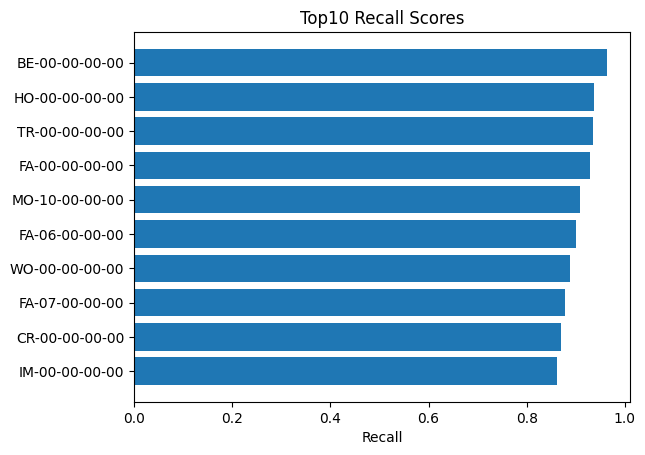

In [16]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()
import collections
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

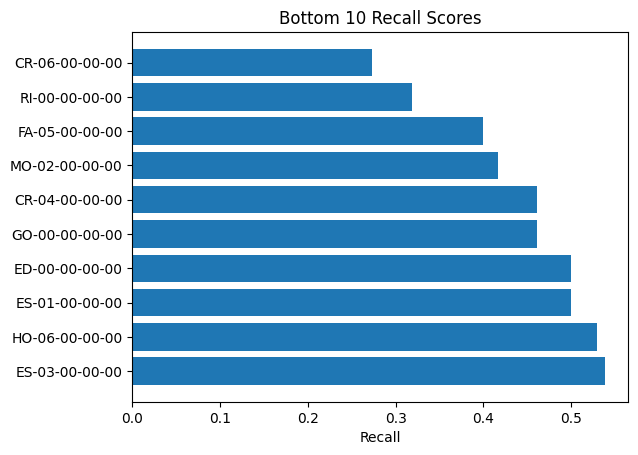

In [17]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()
import collections
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    96.30
1    84.95
2    81.13
3    87.09
4    58.33
5    46.15
6    27.27
7    54.55
8    50.00
9    62.82
10   50.00
11   53.85
12   93.00
13   40.00
14   90.00
15   87.80
16   46.15
17   85.25
18   93.82
19   52.94
20   55.56
21   86.11
22   84.97
23   41.67
24   53.85
25   90.91
26   31.82
27   85.65
28   93.46
29   72.73
30   68.97
31   58.82
32   55.00
33   67.74
34   88.89
35   60.00


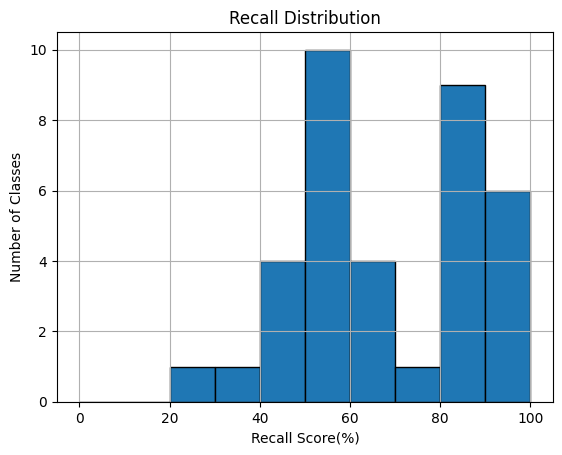

In [18]:
import pylab as pl

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]


recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [19]:
text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"

print(text)
input = sent2vec(text)
input = np.array(input)

predictions = defaultdict() 
prob = defaultdict()
for cls in class_list:
    predictions[cls] = classifier[cls].predict([input])
    prob[cls] = classifier[cls].predict_proba([input])
for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k][0][1], 4))


How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY stat